In [30]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

plt.rcParams["figure.dpi"] = 300

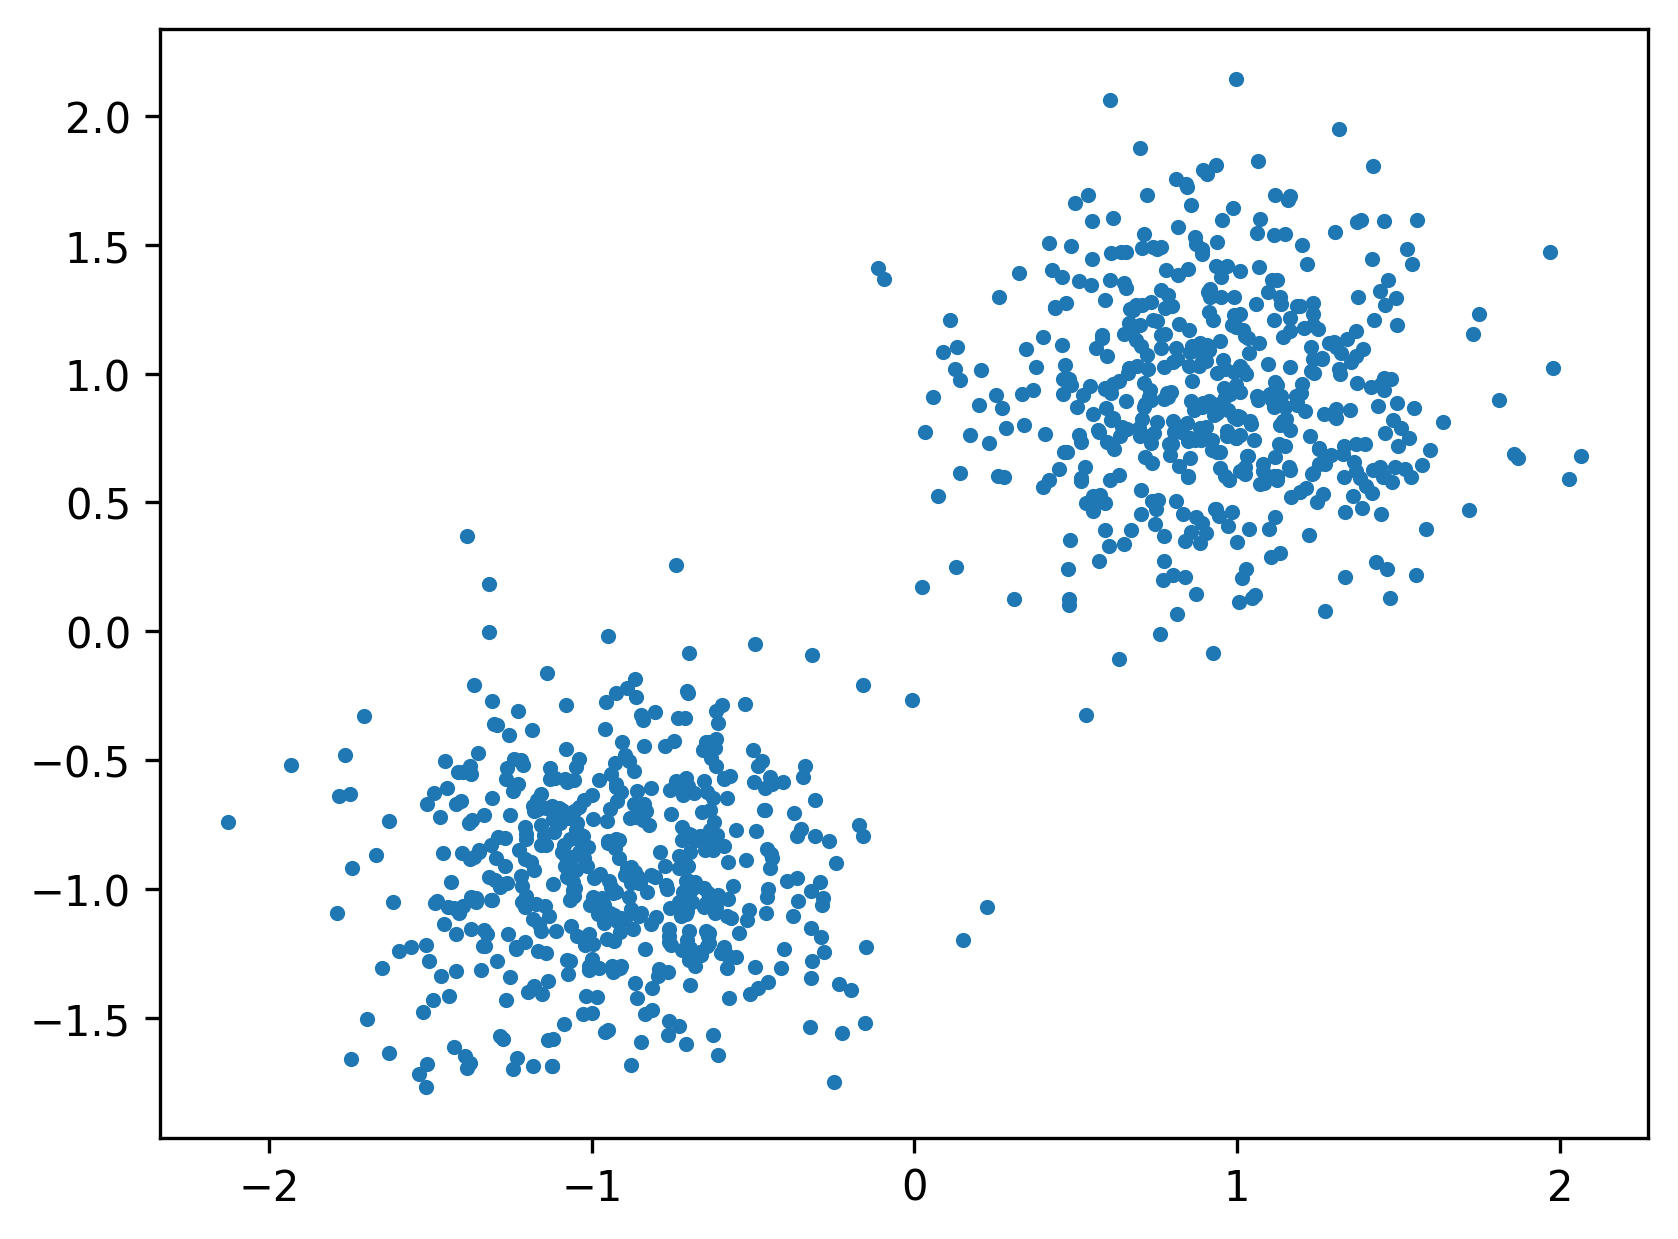

In [31]:
def generate_data(n_samples: int):
    n_samples_distr_0 = n_samples // 2
    n_samples_distr_1 = n_samples - n_samples_distr_0

    mean_0, std_0 = -5, 2
    mean_1, std_1 = 5, 2

    x_0 = torch.normal(mean_0, std_0, size=(n_samples_distr_0, 2))
    x_1 = torch.normal(mean_1, std_1, size=(n_samples_distr_1, 2))
    x = torch.cat([x_0, x_1])
    y = torch.zeros(n_samples)
    y[-n_samples_distr_1:] = 1
    
    x -= x.mean     (dim=0)
    x /= x.std(dim=0)

    return x, y

def one_hot_encoding(x):
    enc = torch.zeros((len(x), torch.max(x).int() + 1))
    indices = torch.stack([torch.arange(len(x)), x.int()])
    enc[*indices] = 1
    return enc

x, y_t = generate_data(1000)
plt.scatter(*x.T, s=7)


# Learn Classifier

100%|██████████| 100/100 [00:03<00:00, 28.53it/s]


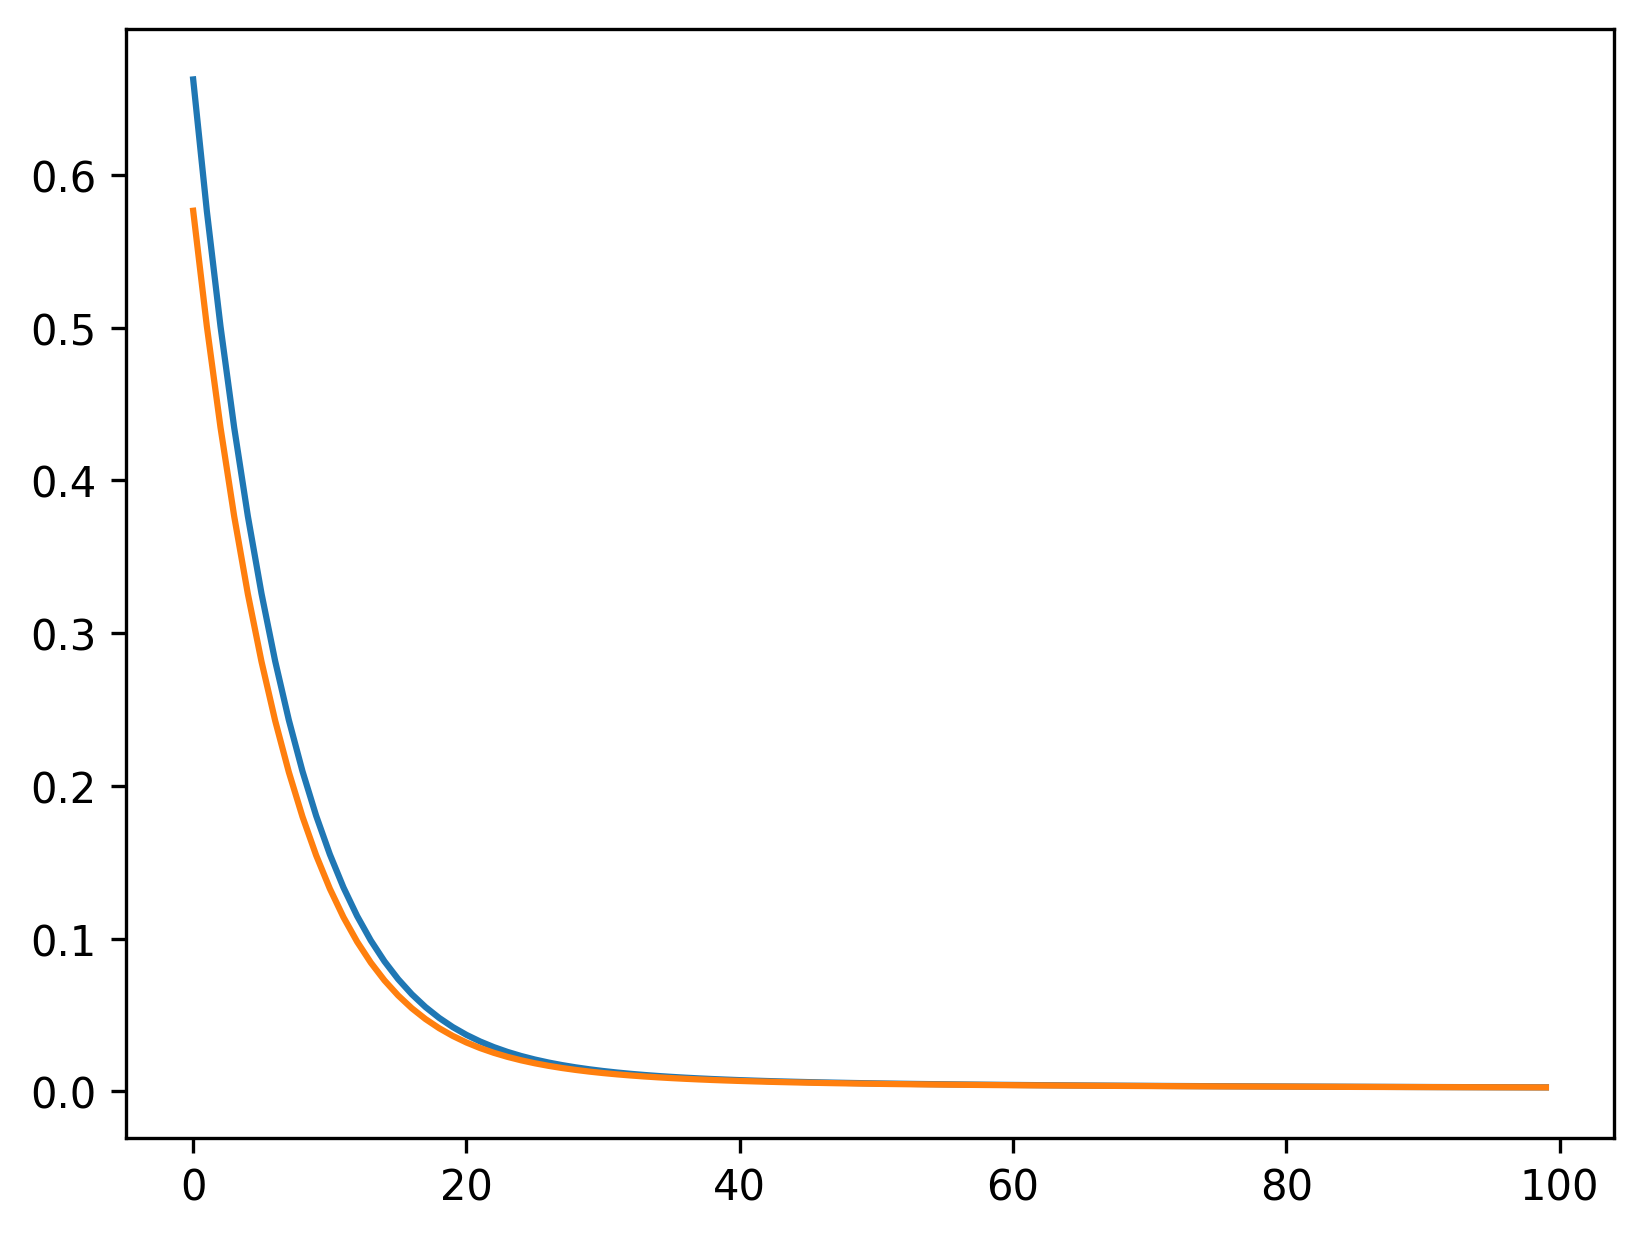

In [32]:
classifier = nn.Sequential(
    nn.Linear(2, 32),
    # nn.SiLU(),
    # nn.Linear(32, 32),
    # nn.SiLU(),
    # nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 2),
)
classifier_criterion = nn.CrossEntropyLoss()
classifier_optimizer = torch.optim.AdamW(classifier.parameters(), lr=0.01)

x_train, y_train = generate_data(100000)
y_train = one_hot_encoding(y_train)
x_val, y_val = generate_data(1000)
y_val = one_hot_encoding(y_val)

train_loss = []
val_loss = []

n_epochs = 100
for epoch in tqdm(range(n_epochs)):
    y_hat = classifier(x_train)
    loss = classifier_criterion.forward(y_hat, y_train)
    classifier_optimizer.zero_grad()
    loss.backward()
    classifier_optimizer.step()

    train_loss.append(loss.item())
    
    classifier.eval()
    y_hat = classifier(x_val)
    loss = classifier_criterion.forward(y_hat, y_val)
    val_loss.append(loss.item())
    classifier.train()

plt.plot(train_loss)
plt.plot(val_loss)

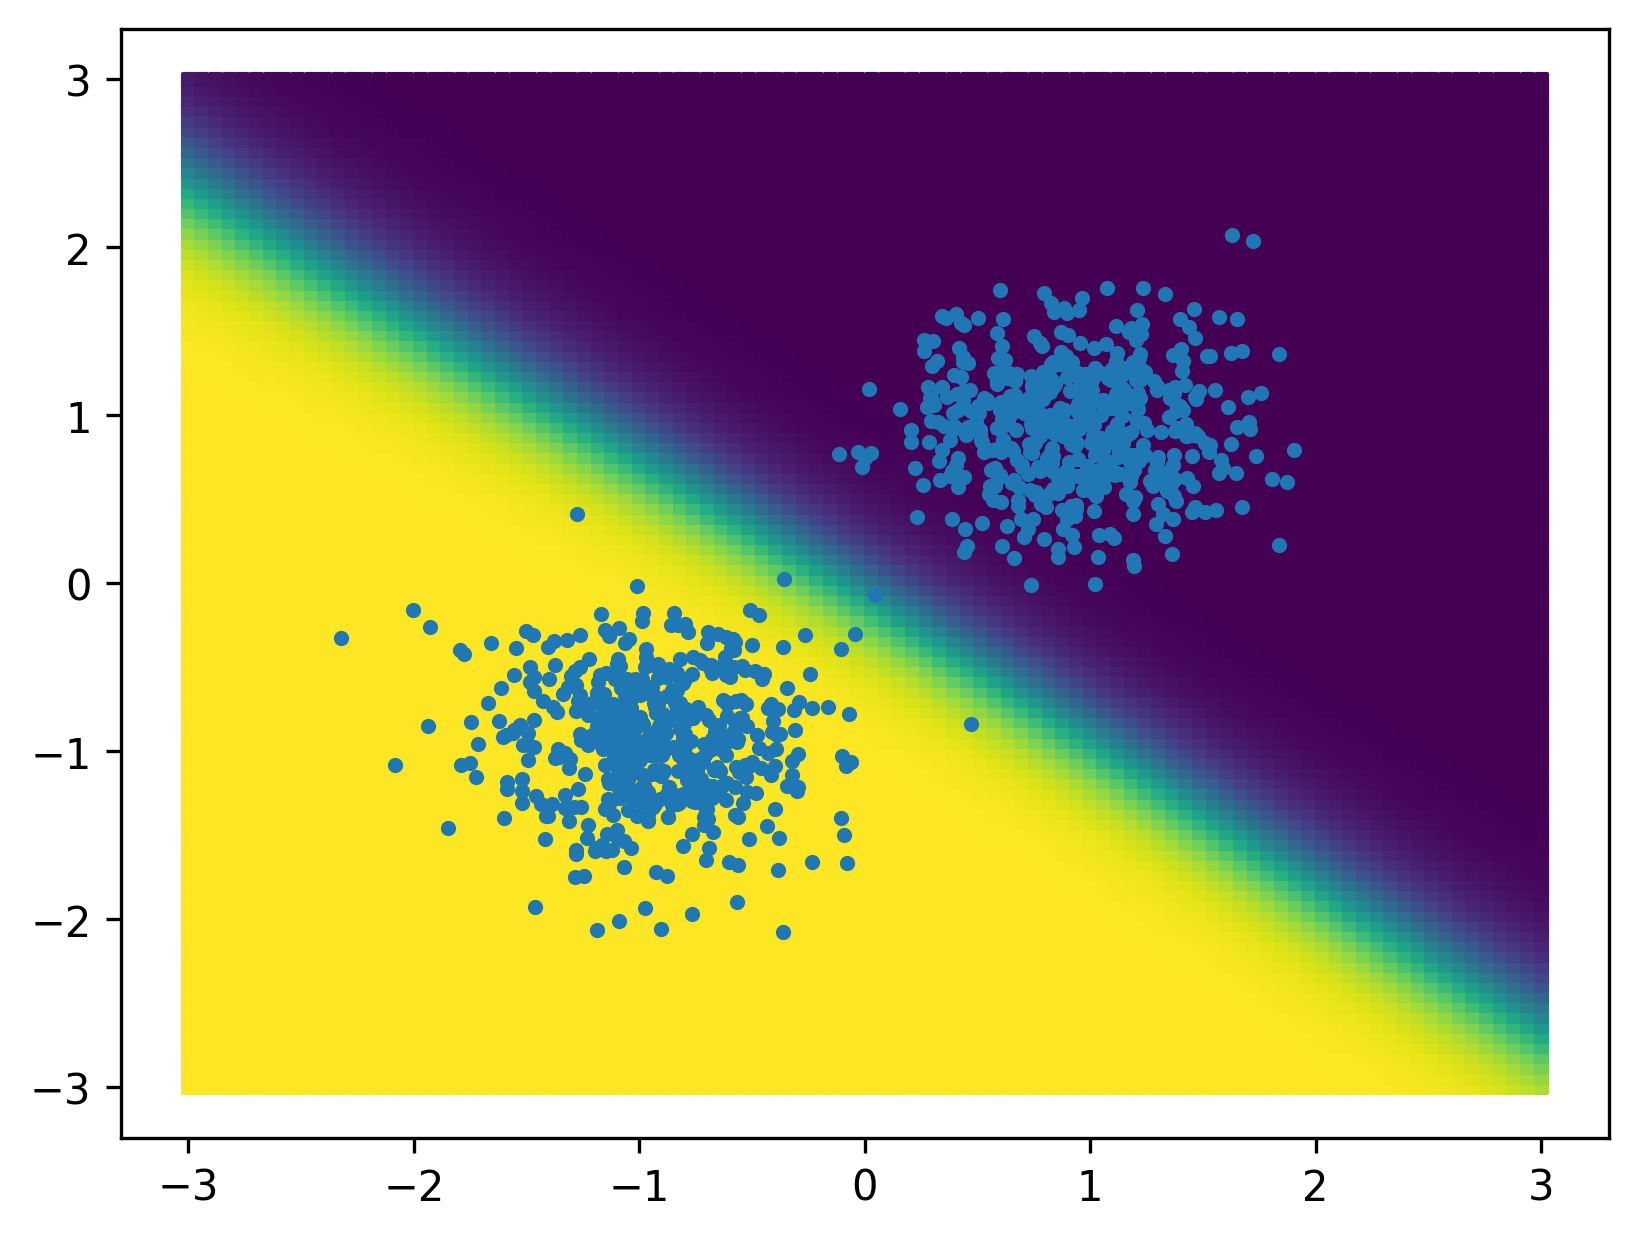

In [33]:
mesh = torch.stack(torch.meshgrid([torch.linspace(-3, 3, 100), torch.linspace(-3, 3, 100)])).reshape(2, -1).T
pred = classifier.forward(mesh)

plt.scatter(*mesh.T, c=torch.softmax(pred, dim=1)[:, 0].detach().numpy(), marker="s", s=7)
plt.scatter(*x_val.T, s=7)


# Learn Diffusion Model

In [34]:
def noise_sample(sample: torch.Tensor, t: float, beta: float) -> torch.Tensor:
    alpha = 1 - beta
    alpha_bar = alpha**(t + 1)

    sample = torch.normal(np.sqrt(alpha_bar) * sample, (1- alpha_bar))
    return sample

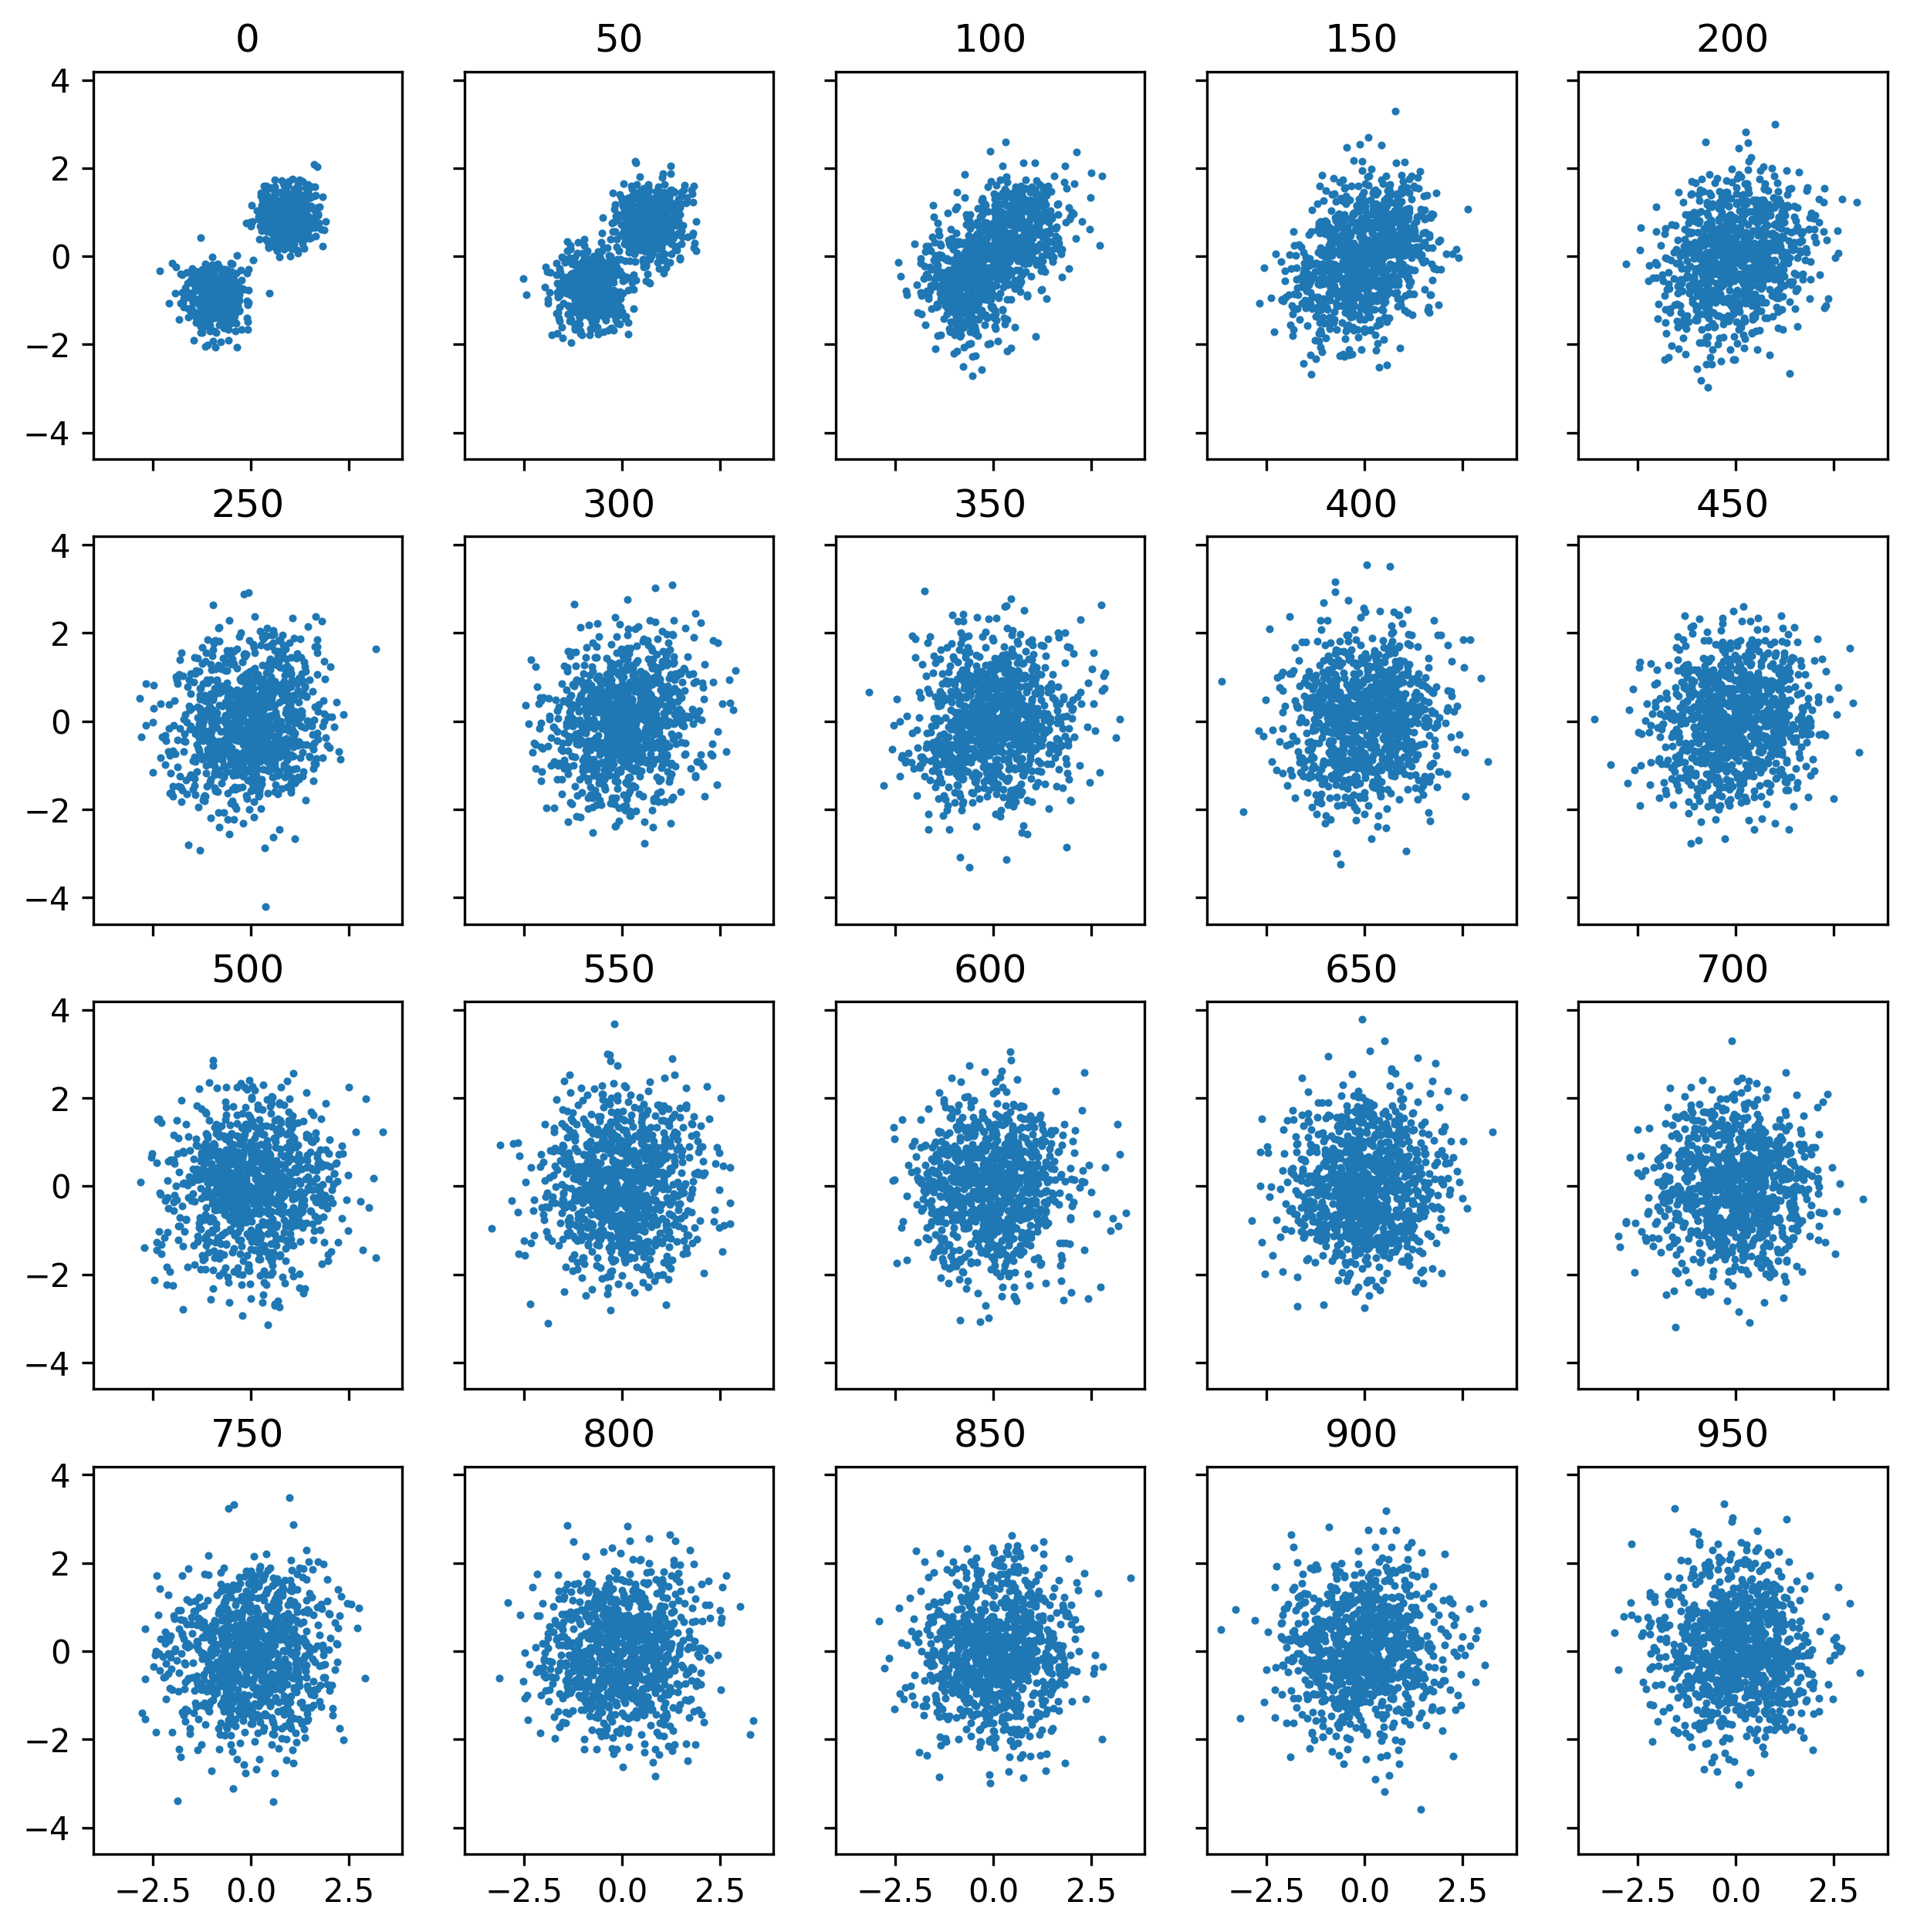

Text(0.5, 0.98, 'Stats over diffusion time')

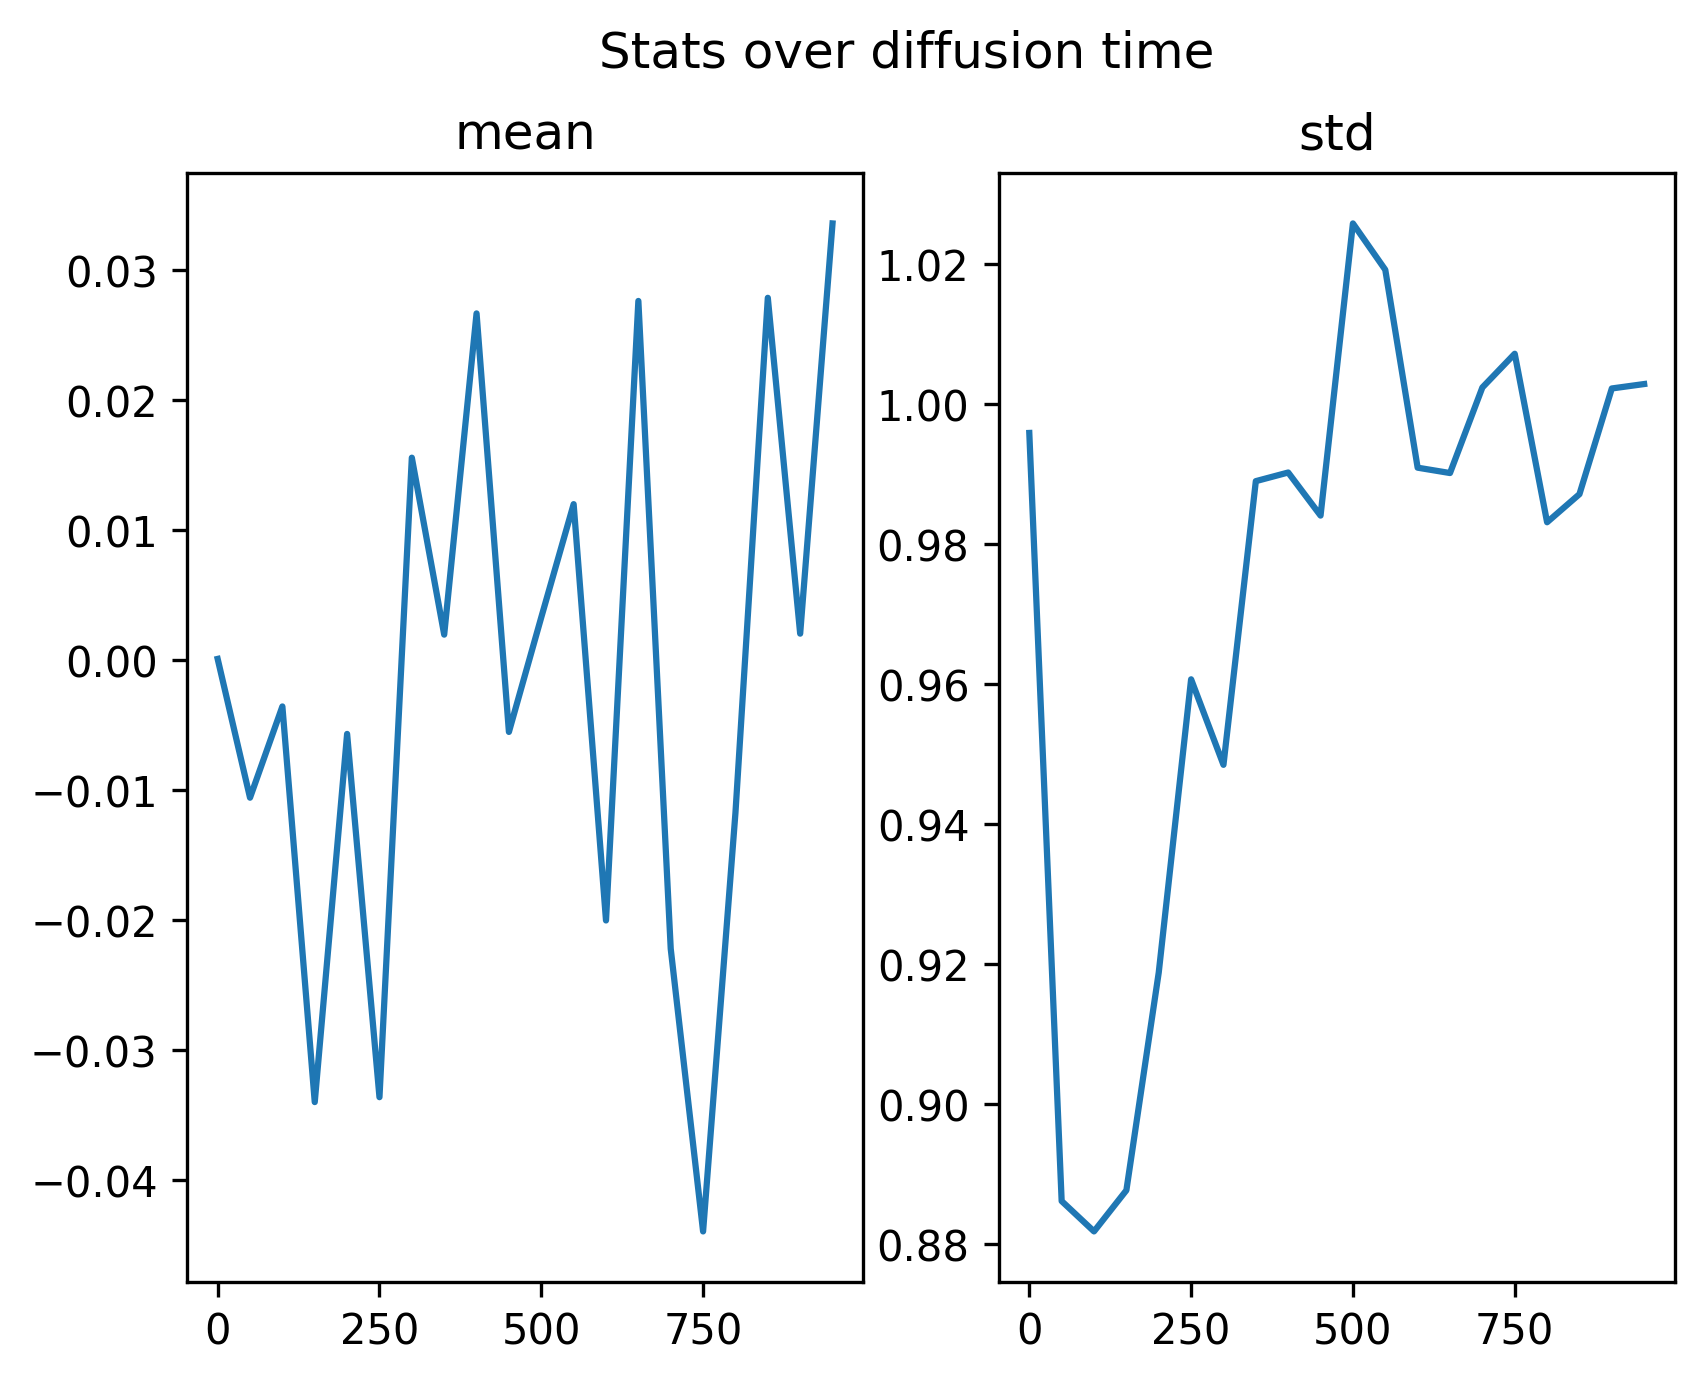

In [35]:
fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(10, 10), sharex=True, sharey=True)
beta = 0.008

mean = []
std = []
for t, ax in enumerate(axes.flatten()):
    x = noise_sample(x_val, t*50, beta)
    mean.append(x.mean())
    std.append(x.std())
    ax.scatter(*x.T, s=2)
    ax.set_title(t * 50)
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.plot(np.linspace(0, 950, len(mean)), mean)
ax1.set_title("mean")
ax2.plot(np.linspace(0, 950, len(std)), std)
ax2.set_title("std")
fig.suptitle("Stats over diffusion time")



100%|██████████| 200/200 [00:32<00:00,  6.25it/s]


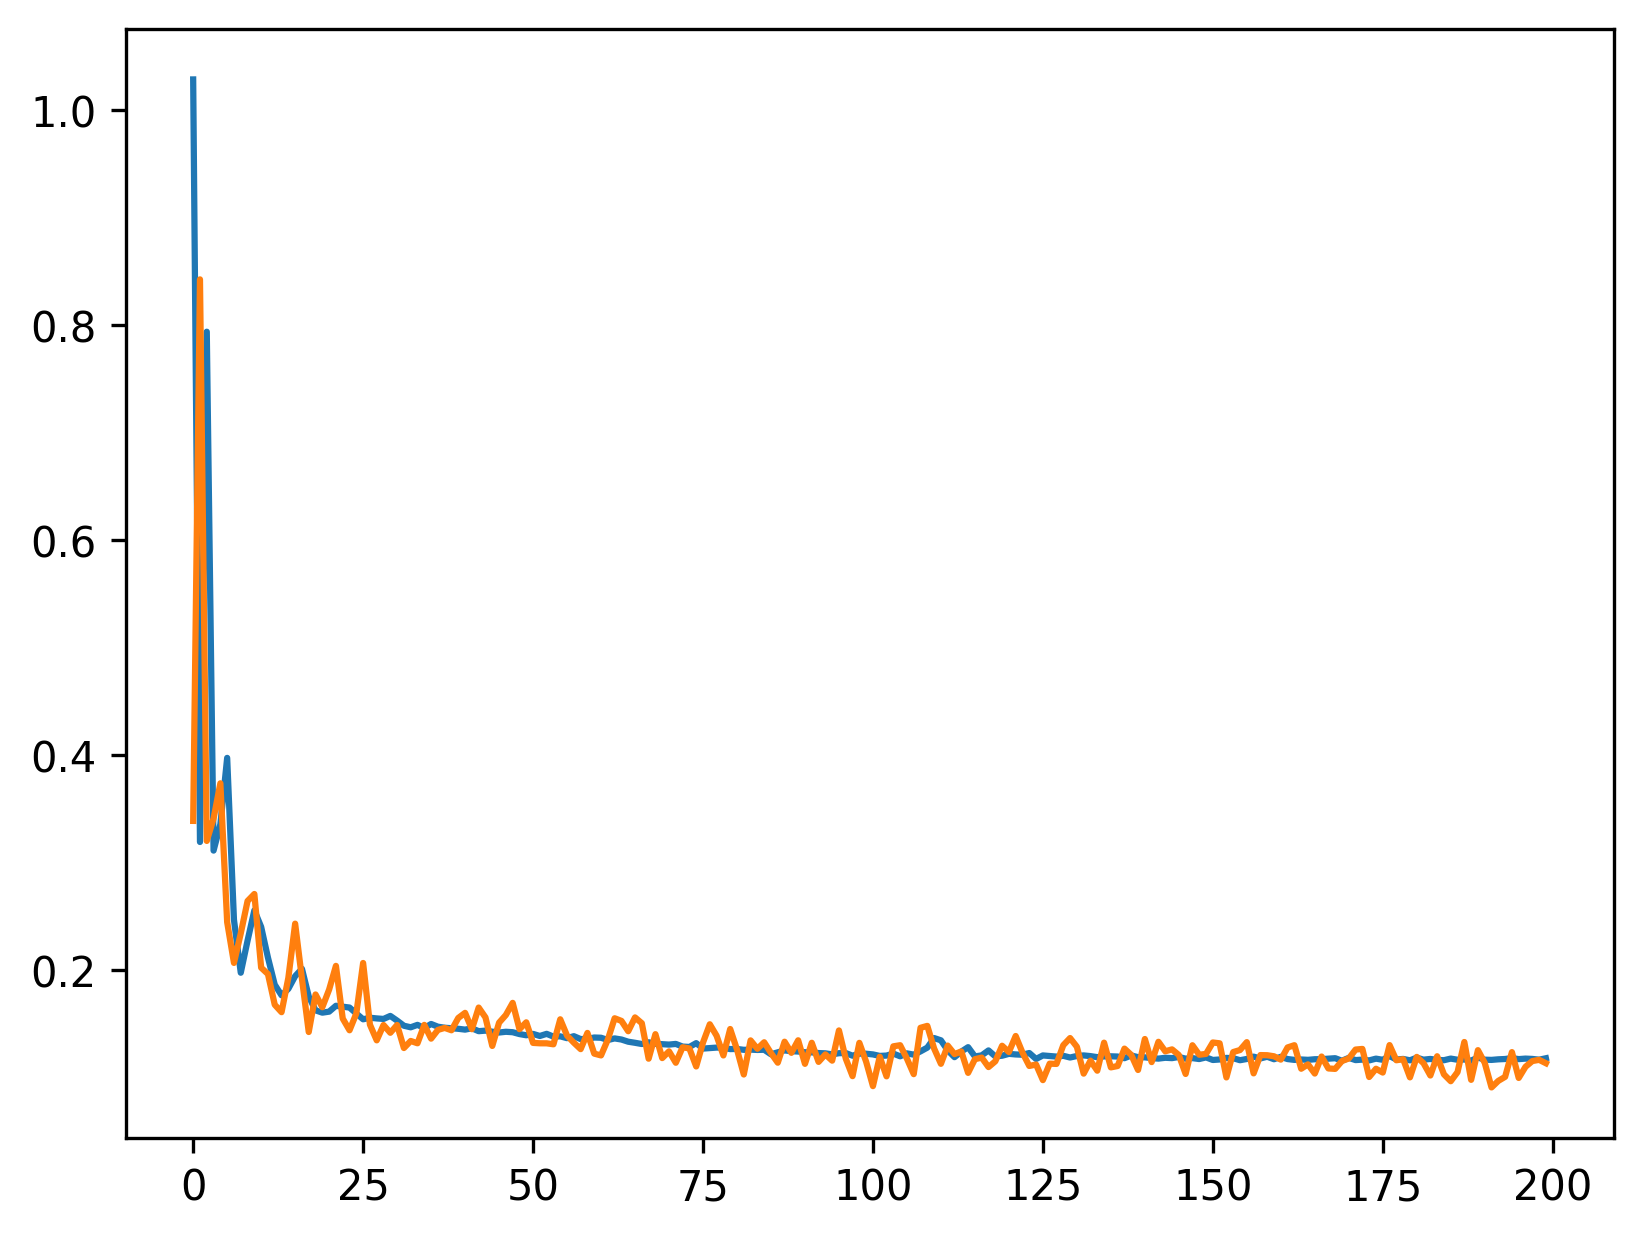

In [36]:
diffusion_model = nn.Sequential(
    nn.Linear(3, 64),
    nn.SiLU(),
    nn.Linear(64, 64),
    nn.SiLU(),
    # nn.Linear(64, 64),
    # nn.SiLU(),
    nn.Linear(64, 2)
)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(diffusion_model.parameters(), lr=0.06)

T = 1000
n_epochs = 200
beta = 0.008

train_loss = []
val_loss = []

for epoch in tqdm(range(n_epochs)):
    alpha = 1 - beta

    # sample diffusion process
    t = np.random.choice(T, size=len(x_train))
    alpha_bar = alpha**(t + 1)
    t = torch.from_numpy(t)
    alpha_bar = torch.from_numpy(alpha_bar)[:, None]

    y_t = torch.normal(0, 1, size=(x_train.shape))
    x_t = np.sqrt(alpha_bar) * x_train + (1- alpha_bar) * y_t
    
    inp = torch.cat([x_t, (t / T)[:, None]], dim=1).float()
    pred = diffusion_model.forward(inp)
    
    loss = criterion.forward(pred, y_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # validate model
    diffusion_model.eval()
    t = np.random.choice(T, size=len(x_val))
    alpha_bar = alpha**(t + 1)
    t = torch.from_numpy(t)
    alpha_bar = torch.from_numpy(alpha_bar)[:, None]

    y_t = torch.normal(0, 1, size=(x_val.shape))
    x_t = np.sqrt(alpha_bar) * x_val + (1- alpha_bar) * y_t
    
    inp = torch.cat([x_t, (t / T)[:, None]], dim=1).float()
    pred = diffusion_model.forward(inp)
    loss = criterion.forward(pred, y_t)
    
    val_loss.append(loss.item())
    diffusion_model.train()

plt.plot(train_loss)
plt.plot(val_loss)

# Sample From diffusion model

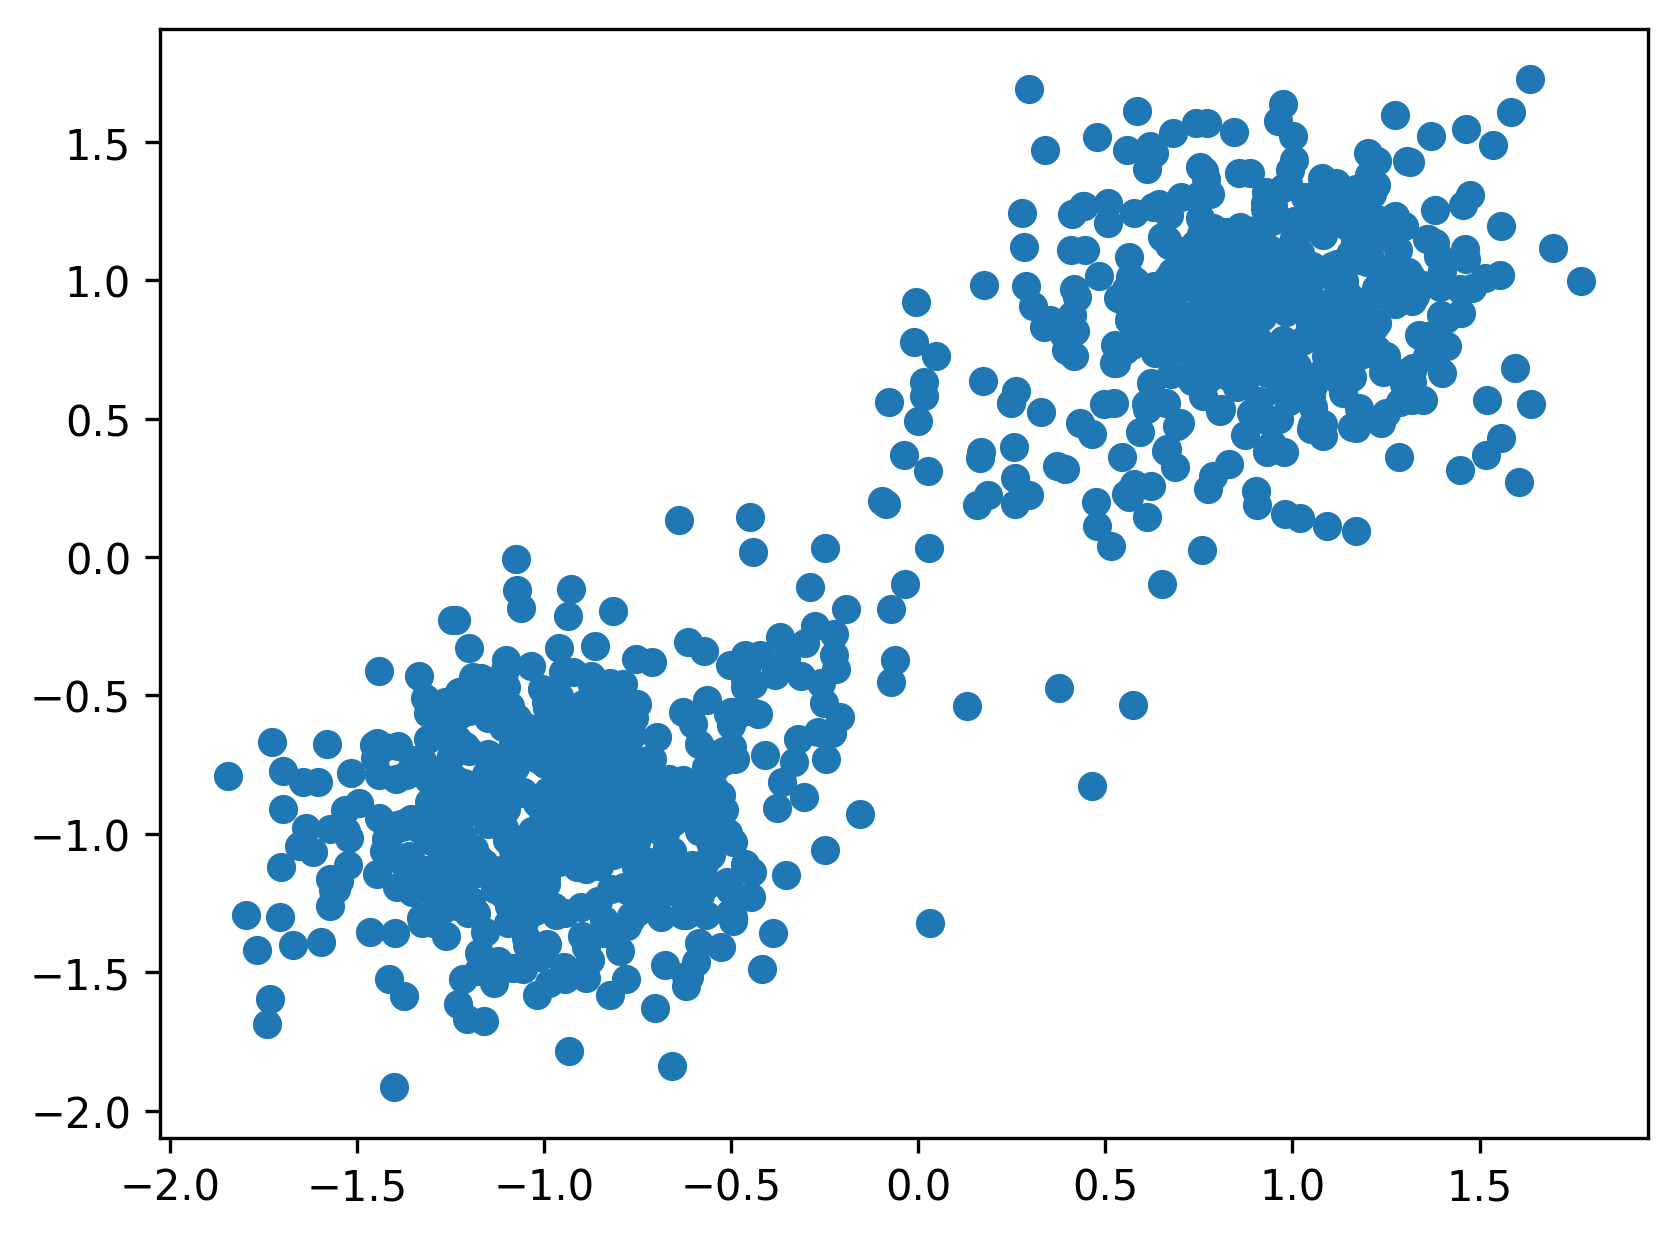

In [37]:
sample_size = 1000

x_t = torch.normal(0, 1, size=(sample_size, 2), requires_grad=True)


for t in reversed(range(T)):
    # t += 1
    alpha = 1 - beta
    alpha_bar = alpha ** (t + 1)
    t = torch.tensor([t])[None].repeat(sample_size, 1)
    inp = torch.cat([x_t, t / T], dim=1).float()
    

    # sigma_t = np.sqrt((1 - alpha ** t) / 1- alpha_bar * beta) 
    sigma_t = np.sqrt(beta) 
    z = torch.normal(0, 1, size=(x_t.shape))
    x_t = (
        1 / np.sqrt(alpha)
        * (x_t - (1 - alpha) / np.sqrt(1 - alpha_bar) * diffusion_model.forward(inp)) # plus or minus
        + sigma_t * z
    )

plt.scatter(*x_t.detach().numpy().T)

1000it [00:01, 535.09it/s]


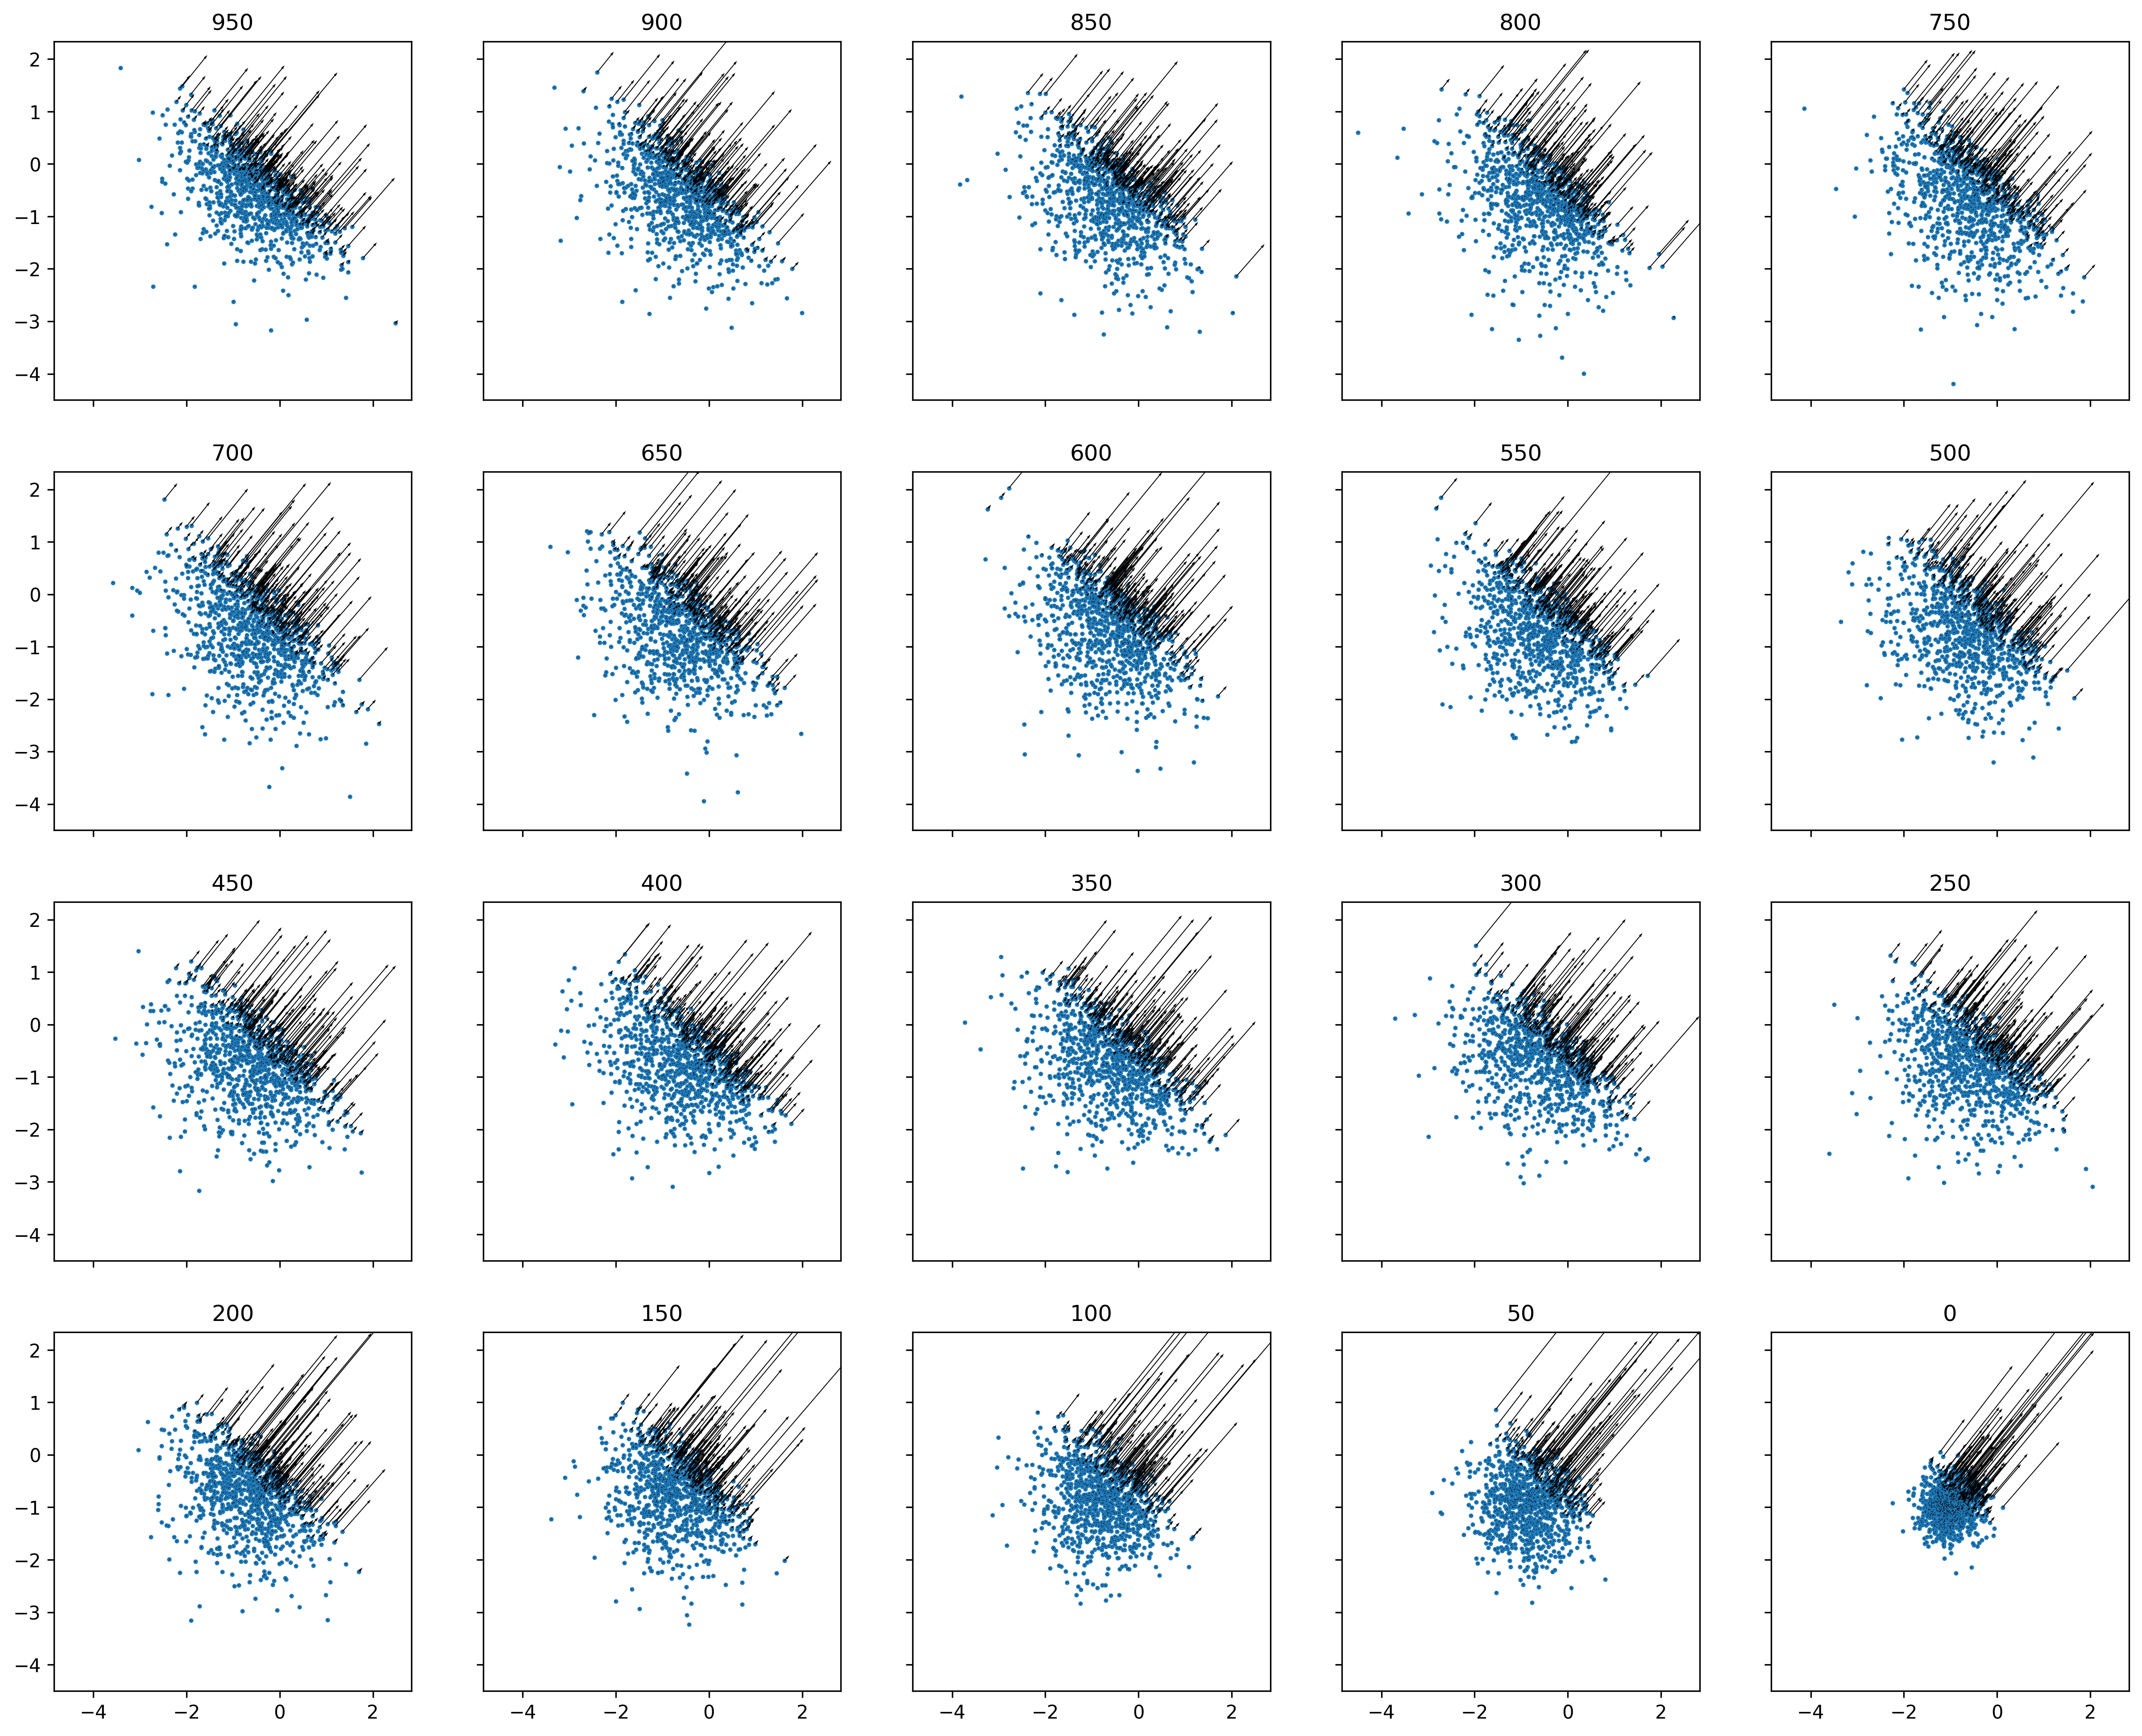

tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]])

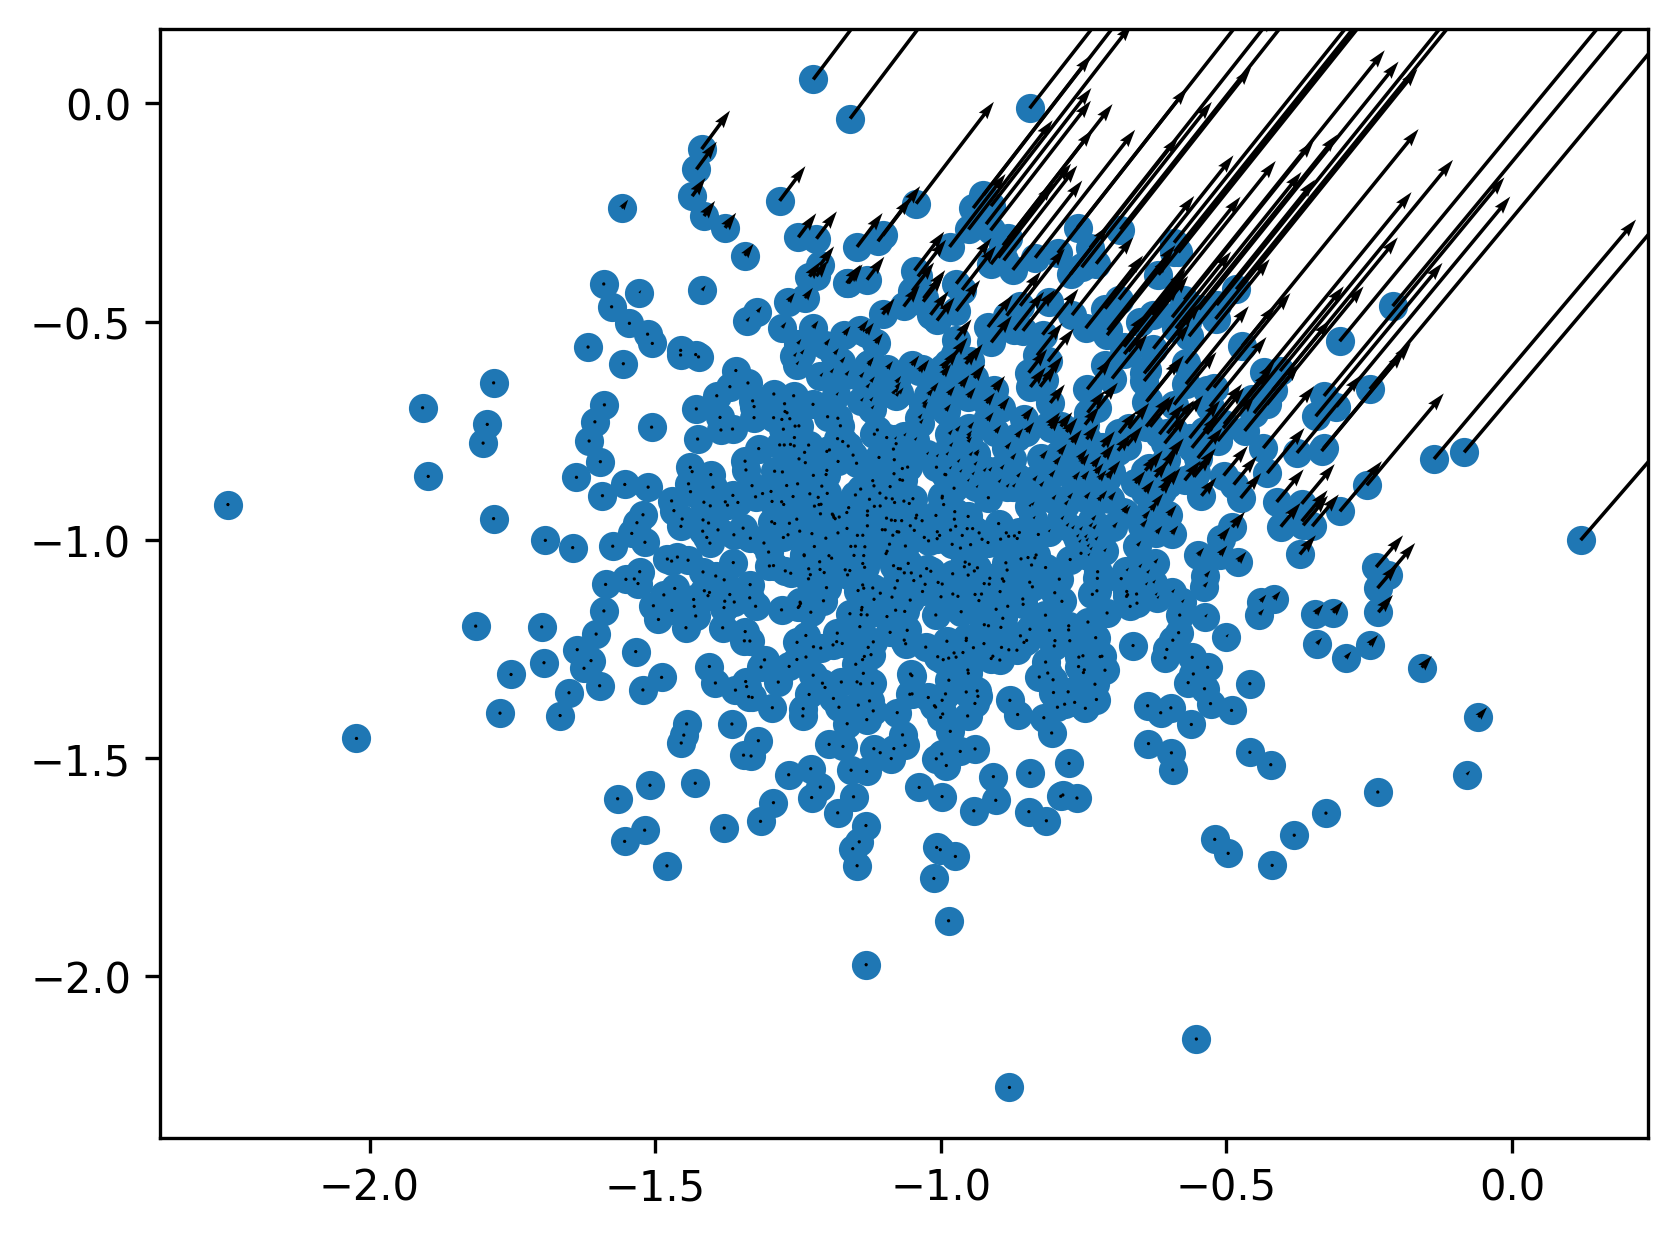

In [39]:
sample_size = 1000

x_t = torch.normal(0, 1, size=(sample_size, 2), requires_grad=True)

label = torch.zeros((sample_size, 2))
label[:, 0] = 1


fig, axs = plt.subplots(ncols=5,nrows=4, sharex=True, sharey=True, figsize=(20, 16))
axs = axs.flatten()
skip = T // len(axs)

for t_idx in tqdm(reversed(range(T))):
#           t_idx += 1

    alpha = 1 - beta
    alpha_bar = alpha ** (t + 1)

    t = torch.tensor([t_idx])[None].repeat(sample_size, 1)
    inp = torch.cat([x_t.detach(), t / T], dim=1).float()
    diffusion_step = diffusion_model.forward(inp.detach())

    x_t.requires_grad_(True)
    class_pred = classifier(x_t)
    loss = classifier_criterion(class_pred, label)
    classifier_grad = torch.autograd.grad(
        outputs=loss, inputs=x_t, grad_outputs=torch.ones_like(loss)
    )
    classifier_grad = classifier_grad[0]

    sigma_t = np.sqrt(beta)
    z = torch.normal(0, 1, size=(x_t.shape))
    x_t = (
        1
        / np.sqrt(alpha)
        * (
            x_t
    - (1 - alpha) / np.sqrt(1 - alpha_bar) * (diffusion_step +  2000 * classifier_grad)
        )  # plus or minus
        + sigma_t * z
    )

    if t_idx % skip == 0:
        plot_idx = T // skip - 1 - t_idx // skip
        axs[plot_idx].scatter(
            *x_t.detach().numpy().T,
            # c=torch.softmax(class_pred, dim=1).detach().numpy()[:, 1]
            s=2
        )
        axs[plot_idx].quiver(
            *x_t.detach().numpy().T, *classifier_grad.detach().numpy().T
        )
        axs[plot_idx].set_title(t_idx)


plt.show()
x_t.requires_grad_(True)
class_pred = classifier(x_t)
loss = classifier_criterion(class_pred, label)
classifier_grad = torch.autograd.grad(
    outputs=loss, inputs=x_t, grad_outputs=torch.ones_like(loss)
)
    
plt.scatter(
    *x_t.detach().numpy().T,
    # c=torch.softmax(class_pred, dim=1).detach().numpy()[:, 1]
)
plt.quiver(
    *x_t.detach().numpy().T, *classifier_grad[0].detach().numpy().T
)

label